<h1>Comprehensive Analysis of Bicycle Thefts in Toronto</h1>


<img src="toronto_image.jpeg" alt="Alt Text" width="500"/>

## Table of Contents

* [Data Collection](#section-1)
* [Data Cleaning & Transformation](#section-2)
* [Dataset Analysis](#section-3)
* [External Factors Analysis](#section-4)
    * [What impact does the rising cost of living have on bicycle theft?](#section-5)
    * [What weather conditions most influence bicycle theft?](#section-6)
    * [How do varying education levels across different wards impact bicycle theft rates?](#section-7)
* [Power BI Visualization](#section-8)





## Introduction

* Cycling is a fun, fast, and healthy way to get around, but without the proper precautions, many cyclists fall victim to bicycle theft.

* The purpose of this study is to perform an Analysis of the Bicycle Theft Dataset provided by the city of Toronto.

* I aim to gain valuable insights into how employment rates, weather, the consumer price index, and other factors affect bicycle theft rates.

# Data Collection <a class="anchor" id="section-1"></a>

In [41]:
# Importing Libraries
import requests
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import json
import folium
import statsmodels.api as sm
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio


from io import StringIO
from datetime import datetime
from sklearn.linear_model import LinearRegression
from IPython.display import display
from sklearn.linear_model import LinearRegression
from IPython.display import Image

pd.options.mode.chained_assignment = None 


In [42]:
# Retreive the Bicycle Vehicle Theft Dataset from Toronto Open Data API
base_url = "https://ckan0.cf.opendata.inter.prod-toronto.ca"


# Datasets are called "packages". Each package can contain many "resources"
url = base_url + "/api/3/action/package_show"
params = { "id": "bicycle-thefts"}
package = requests.get(url, params = params).json()

# To get resource data:
for idx, resource in enumerate(package["result"]["resources"]):

    # For datastore_active resources:
    if resource["datastore_active"]:

        # To get all records in CSV format:
        url = base_url + "/datastore/dump/" + resource["id"]
        try:
            resource_dump_data = requests.get(url).text
            # Success message
            print("Bicycle theft data retrieved successfully.")
        except requests.exceptions.RequestException as e:
            # Error message
            print(f"Error retrieving data: {e}")    

# Create pandas Dataframe
csv_file = StringIO(resource_dump_data)
bicycle_theft_data = pd.read_csv(csv_file)

Bicycle theft data retrieved successfully.


In [43]:
# Retreive the CPI Value from the Bank of Canada API

url = "https://www.bankofcanada.ca/valet/observations/INDINF_CPI_M/json?start_date=2010-01-01"


response = requests.get(url)

# Check if the request was successful
if response.status_code == 200:
   
        data = response.json()
        
        # Extract the observations
        observations = data.get('observations', [])
        
        # Create a list to store the data
        records = []

        # Loop through each observation and extract the date and CPI value
        for obs in observations:
            date = obs.get('d')
            cpi_value = obs.get('INDINF_CPI_M', {}).get('v')
            records.append([date, cpi_value])

        # Print success message
        print("CPI Value retrieved successfully.")

        # Create the DataFrame
        cpi_inflation_data = pd.DataFrame(records, columns=['Date', 'CPI_Inflation'])
        cpi_inflation_data['Date'] = pd.to_datetime(cpi_inflation_data['Date'])
        
else:
    print(f"Request failed with status code: {response.status_code}")

# Retreive Total CPI  from the Bank of Canada API
url2 = "https://www.bankofcanada.ca/valet/observations/V41690973/json?start_date=2010-01-01"

response2 = requests.get(url2)

# Check if the request was successful
if response2.status_code == 200:
   
        data2 = response2.json()
        
        # Extract the observations
        observations = data2.get('observations', [])
        
        # Create a list to store the data
        records2 = []

        # Loop through each observation and extract the date and CPI value
        for obs in observations:
            date = obs.get('d')
            total_cpi = obs.get('V41690973', {}).get('v')
            records2.append([date, total_cpi])

        # Print success message
        print("Total CPI retrieved successfully.")

        # Create the DataFrame
        cpi_base_data = pd.DataFrame(records2, columns=['Date', 'CPI_Base'])
        cpi_base_data['Date'] = pd.to_datetime(cpi_base_data['Date'])
        
else:
    print(f"Request failed with status code: {response2.status_code}")

# Merge the 2 dataframe by the Date column 
cpi_data = pd.merge(cpi_base_data, cpi_inflation_data, on='Date')

CPI Value retrieved successfully.
Total CPI retrieved successfully.


In [44]:
# Retreive the Toronto wheather dataset csv from https://toronto.weatherstats.ca/download.html

file_path = 'TOR_historical_weather.csv'

# Attempt to read the CSV file into a DataFrame
try:
    weather_data = pd.read_csv(file_path)
    
    # Check if the DataFrame is empty
    if weather_data.empty:
        print("Weather file is empty.")
    else:
        print("Weather Data retreived successfully")
except Exception as e:
    print(f"Error: {e}")

Weather Data retreived successfully


In [45]:
# Retreive census data csv from https://open.toronto.ca/dataset/ward-profiles-25-ward-model/

file_path = 'census_data.xlsx'

# Attempt to read the CSV file into a DataFrame
try:
    census_data = pd.read_excel(file_path)
    
    # Check if the DataFrame is empty
    if census_data.empty:
        print("Census file is empty.")
    else:
        print("The Census file was read successfully.")
except Exception as e:
    print(f"Error: {e}")

The Census file was read successfully.


# Data Cleaning & Transformation <a class="anchor" id="section-2"></a>

#### First, I established a common timeframe across all datasets. The analysis will focus on data from the most recent 10-year period, considering only complete calendar years.

In [46]:
# Convert Date columns
cpi_data['Date'] = pd.to_datetime(cpi_data['Date'])
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Get current year number
current_year = datetime.now().year

# Get last year number
last_year = (current_year - 1)

# Get year, 10 years ago
ten_years_ago = (current_year - 10)

# Create new column in CPI data for year
cpi_data['Year'] = cpi_data['Date'].dt.year

# Create new column in CPI data for year
weather_data['Year'] = weather_data['date'].dt.year

# Filter all 3 datasets for the last decade without including this year's data. 
filtered_bicycle_theft_data1 = bicycle_theft_data[bicycle_theft_data['OCC_YEAR'].between(ten_years_ago, last_year)]
cpi_data1 = cpi_data[cpi_data['Year'].between(ten_years_ago, last_year)]
weather_data1 = weather_data[weather_data['Year'].between(ten_years_ago, last_year)]




##### Next, I added new Date columns to merge the datasets. Since the CPI data is provided on a monthly basis, I created a new column representing the Year/Month in both the CPI dataset and the bicycle theft dataset. On antoher hand, since the weather datas is provided daily, I added a Year/Month/Day column to the bicycle theft dataset.

In [47]:
# Map Month Names to Numbers
month_mapping = {
    'January': '01',
    'February': '02',
    'March': '03',
    'April': '04',
    'May': '05',
    'June': '06',
    'July': '07',
    'August': '08',
    'September': '09',
    'October': '10',
    'November': '11',
    'December': '12'
}

# Add Year-Month Columns
filtered_bicycle_theft_data1.loc[:,'Year-Month'] = filtered_bicycle_theft_data1['OCC_YEAR'].astype(str) + '-' + filtered_bicycle_theft_data1['OCC_MONTH'].map(month_mapping)
cpi_data1.loc[:, 'Year-Month'] = cpi_data1['Date'].dt.to_period('M').astype(str)

# Add Occurence Year-Month-Day Columns
filtered_bicycle_theft_data1.loc[:,'Occ_Full_Date'] = filtered_bicycle_theft_data1['OCC_YEAR'].astype(str) + '-' + filtered_bicycle_theft_data1['OCC_MONTH'].map(month_mapping) + '-' + filtered_bicycle_theft_data1['OCC_DAY'].astype(str)

# Add Report Year-Month-Day Columns
filtered_bicycle_theft_data1.loc[:,'Report_Full_Date'] = filtered_bicycle_theft_data1['REPORT_YEAR'].astype(str) + '-' + filtered_bicycle_theft_data1['REPORT_MONTH'].map(month_mapping) + '-' + filtered_bicycle_theft_data1['REPORT_DAY'].astype(str)



#### Now I will look at each dataset indidually to clean and transform the data as needed. Starting with the Weather Dataset, I will verify if there are any duplicates or null values.

In [48]:
# Print number of duplicate values if any.
duplicates = weather_data['date'].duplicated().any()

if duplicates > 0:
    print(f"The dataset has {duplicates} duplicates.")
else:
    print("The dataset does not have duplicates.")

The dataset does not have duplicates.


##### Here, I verified how many missing values were present. A few columns had a high percentage of missing values. 

In [49]:
# Calculate the count of null values for each column
null_count = weather_data.isnull().sum()

# Calculate the percentage of null values for each column
null_percentage = (weather_data.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
null_summary = pd.DataFrame({
    'Null Count': null_count,
    'Null Percentage': null_percentage
})

# Filter to show only columns with null values
null_summary = null_summary[null_summary['Null Count'] > 0]

#Display null count and percentage
display(null_summary)

Null Count  Null Percentage
max_humidex                          2858            71.45
min_windchill                        2687            67.18
max_wind_gust                         723            18.08
wind_gust_dir_10s                     723            18.08
max_health_index                     3760            94.00
avg_hourly_health_index              3760            94.00
avg_health_index                     3760            94.00
min_health_index                     3760            94.00
precipitation                          23             0.57
rain                                   34             0.85
snow                                   24             0.60
snow_on_ground                       2991            74.78
sunrise_hhmm                          140             3.50
sunrise_unixtime                      140             3.50
sunrise_f                             140             3.50
sunset_hhmm                           140             3.50
sunset_unixtime                       140             3.50
sunset_f                              140             3.50
daylight                              140             3.50
min_uv_forecast                       802            20.05
max_uv_forecast                       802            20.05
min_high_temperature_forecast         140             3.50
max_high_temperature_forecast         140             3.50
min_low_temperature_forecast          140             3.50
max_low_temperature_forecast          140             3.50
solar_radiation                      4000           100.00
max_cloud_cover_4                    4000           100.00
avg_hourly_cloud_cover_4             4000           100.00
avg_cloud_cover_4                    4000           100.00
min_cloud_cover_4                    4000           100.00
max_cloud_cover_8                      56             1.40
avg_hourly_cloud_cover_8               56             1.40
avg_cloud_cover_8                      56             1.40
min_cloud_cover_8                      56             1.40
max_cloud_cover_10                   4000           100.00
avg_hourly_cloud_cover_10            4000           100.00
avg_cloud_cover_10                   4000           100.00
min_cloud_cover_10                   4000           100.00

##### I decided to drop any column with more than 15% missing values. Then, I decided to drop two additional columns ('sunrise_hhmm' and 'sunset_hhmm') since they were not useful for our analysis. Finally, I filled the remaining columns containing null values with the average of their respective columns.

In [50]:
# Drop columns with more than 15% missing values
columns_to_drop = null_summary[null_summary['Null Percentage'] >= 15].index
filtered_weather_data = weather_data.drop(columns=columns_to_drop)

# Drop 'sunrise_hhmm' and 'sunset_hhmm' columns
filtered_weather_data1 = filtered_weather_data.drop(columns=['sunrise_hhmm', 'sunset_hhmm'])

# Numeric columns
numeric_columns = filtered_weather_data1.select_dtypes(include=['number']).columns
filtered_weather_data1[numeric_columns] = filtered_weather_data1[numeric_columns].apply(lambda x: x.fillna(x.mean()), axis=0)


# Verify that all null values are handled
null_count = filtered_weather_data1.isnull().sum()
null_percentage = (filtered_weather_data1.isnull().mean() * 100).round(2)

null_summary = pd.DataFrame({
    'Null Count': null_count,
    'Null Percentage': null_percentage
})

# Verify that there are no more null values
null_summary = null_summary[null_summary['Null Count'] > 0]
display(null_summary)




Empty DataFrame
Columns: [Null Count, Null Percentage]
Index: []

#### The bicycle dataset has a significant amount of missing values. Since our analysis depends on the count of bicycle thefts, it is important to retain all records by handling missing values appropriately. I will begin by removing duplicates and then address the missing values.

In [51]:
# Get sum of duplicate values
duplicate_count = filtered_bicycle_theft_data1['EVENT_UNIQUE_ID'].duplicated().sum()

# Print Count of duplicate values
if duplicate_count > 0:
    print(f"The column has {duplicate_count} duplicates.")
else:
    print("The column does not have duplicates.")


The column has 3751 duplicates.


In [52]:
# Remove duplicate values
filtered_bicycle_theft_data2 = filtered_bicycle_theft_data1.drop_duplicates(subset=['EVENT_UNIQUE_ID'])

# Get sum of duplicate values
duplicate_count = filtered_bicycle_theft_data2['EVENT_UNIQUE_ID'].duplicated().sum()

# Print Count of duplicate values
if duplicate_count > 0:
    print(f"The column has {duplicate_count} duplicates.")
else:
    print("Duplicate entries have been successfully eliminated.")



Duplicate entries have been successfully eliminated.


##### Then, I verfiried wich columns had missing values and handled them appropriatly.

In [53]:
# Calculate the count of null values for each column
null_count = filtered_bicycle_theft_data2.isnull().sum()

# Calculate the percentage of null values for each column
null_percentage = (filtered_bicycle_theft_data2.isnull().mean() * 100).round(2)

# Create a DataFrame to display the results
null_summary = pd.DataFrame({
    'Null Count': null_count,
    'Null Percentage': null_percentage
})

# Filter to show only columns with null values
null_summary = null_summary[null_summary['Null Count'] > 0]

# Display null count and percentage
display(null_summary)

Null Count  Null Percentage
OCC_HOUR           1675             5.37
REPORT_HOUR         602             1.93
BIKE_MAKE           157             0.50
BIKE_MODEL        11489            36.81
BIKE_SPEED         2354             7.54
BIKE_COLOUR        2621             8.40
BIKE_COST          3524            11.29

##### I decided to drop the BIKE_MODEL column since it contained a high percentage of missing values (more than 36%). I also dropped the OCC_DATE and REPORT_DATE columns, as other date columns in the dataset (with 0 null values) can be used to create a complete 'occurrence date column' and a complete 'report date column'.


In [54]:
# Drop BIKE_MODEL, OCC_DATE & REPORT_DATE
filtered_bicycle_theft_data3 = filtered_bicycle_theft_data2.drop(columns=['REPORT_DATE', 'OCC_DATE', 'BIKE_MODEL'], inplace=False)

##### The columns BIKE_MAKE, BIKE_COLOUR, BIKE_SPEED, and BIKE_COST had a small percentage of missing values. To maintain the record count for all thefts, these columns were filled with their respective mode or mean.

In [55]:
# Bike Make & Bike Color fill na with mode (categorical column)
bike_make_mode = filtered_bicycle_theft_data3['BIKE_MAKE'].mode()[0]
filtered_bicycle_theft_data3.loc[:, 'BIKE_MAKE'] = filtered_bicycle_theft_data3['BIKE_MAKE'].fillna(bike_make_mode)

bike_colour_mode = filtered_bicycle_theft_data3['BIKE_COLOUR'].mode()[0]
filtered_bicycle_theft_data3.loc[:, 'BIKE_COLOUR'] = filtered_bicycle_theft_data3['BIKE_COLOUR'].fillna(bike_colour_mode)

# Bike Speed & Bike Cost fill na with mean (numerical column)
bike_speed_mean = filtered_bicycle_theft_data3['BIKE_SPEED'].mean()
filtered_bicycle_theft_data3.loc[:, 'BIKE_SPEED'] = filtered_bicycle_theft_data3['BIKE_SPEED'].fillna(bike_speed_mean)

bike_cost_mean = filtered_bicycle_theft_data3['BIKE_COST'].mean()
filtered_bicycle_theft_data3.loc[:, 'BIKE_COST'] = filtered_bicycle_theft_data3['BIKE_COST'].fillna(bike_cost_mean)

##### The 2 columns OCC_HOUR and REPORT_HOUR are important for our analysis since we want to determine when thefts occur. A couple of months ago, these columns did not have any missing values. However, they now contain close to 2000 missing values. During our last data refresh, it seems that the city of toronto removed all the hour values of midnight (0) from the dataset. We will fill the missing values in these columns with 0 (for midnight) and will continue to investigate this issue.


In [56]:
#Needs further investigation
filtered_bicycle_theft_data3['OCC_HOUR'] = filtered_bicycle_theft_data3['OCC_HOUR'].fillna(0)
filtered_bicycle_theft_data3['REPORT_HOUR'] = filtered_bicycle_theft_data3['OCC_HOUR'].fillna(0)

In [57]:
# Verify that all null vlaues are gone
filtered_bicycle_theft_data3.isnull().sum()

_id                 0
EVENT_UNIQUE_ID     0
PRIMARY_OFFENCE     0
OCC_YEAR            0
OCC_MONTH           0
OCC_DOW             0
OCC_DAY             0
OCC_DOY             0
OCC_HOUR            0
REPORT_YEAR         0
REPORT_MONTH        0
REPORT_DOW          0
REPORT_DAY          0
REPORT_DOY          0
REPORT_HOUR         0
DIVISION            0
LOCATION_TYPE       0
PREMISES_TYPE       0
BIKE_MAKE           0
BIKE_TYPE           0
BIKE_SPEED          0
BIKE_COLOUR         0
BIKE_COST           0
STATUS              0
geometry            0
Year-Month          0
Occ_Full_Date       0
Report_Full_Date    0
dtype: int64

##### Since the Bicycle theft dataset has no column for the address, we will extract the Latitude and Longitude from the geometry column to obtain the address.

In [58]:
# Extract latitude and longitude coordinates from a JSON geometry object (geometry column)
def extract_coordinates(geometry):
    geometry_json = json.loads(geometry)
    return geometry_json['coordinates'][1], geometry_json['coordinates'][0]

# Apply function to create latitude and longitude columns
filtered_bicycle_theft_data3['Latitude'], filtered_bicycle_theft_data3['Longitude'] = zip(*filtered_bicycle_theft_data3['geometry'].apply(extract_coordinates))

##### The next step is to obtain the address from the extracted coordinates (latitude and longitude). We used the Nominatim API to retrieve the address. Due to the length of this dataset, the process took around 5 hours. Once finished, we saved the coordinates with their corresponding addresses in a separate Excel mapping file to avoid repeating this lengthy process in the future. Down below is the script I used to get the street name, postal code and, the ward.

In [59]:
'''
from tqdm import tqdm
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderUnavailable, GeocoderTimedOut
import time

# Function to retrieve address components from latitude and longitude using a geocoding service.
def get_address_components(latitude, longitude, retries=3, timeout=1):
    geolocator = Nominatim(user_agent="1290mygeocover1290", timeout=timeout)
    
    for attempt in range(retries):
        try:
            location = geolocator.reverse((latitude, longitude), language='en')
            address_components = location.raw['address']
            return address_components
        except (GeocoderUnavailable, GeocoderTimedOut) as e:
            print(f"Attempt {attempt + 1} failed: {e}")
            if attempt < retries - 1:
                time.sleep(2)  # Wait for 2 seconds before retrying
            else:
                print("All attempts failed.")
                return None

# Iterate over each row in the dataset and retrieve address components based on latitude and longitude coordinates
num_rows = len(filtered_bicycle_theft_data3)
# Initialize a progress bar to track the iteration progress
with tqdm(total=num_rows) as pbar:
    for index, row in filtered_bicycle_theft_data3.iterrows():
        # Retrieve address components using the defined function
        address_components = get_address_components(row['Latitude'], row['Longitude'])
        if address_components:
            # Update the DataFrame with the retrieved address components
            filtered_bicycle_theft_data3.at[index, 'Road'] = address_components.get('road', None)
            filtered_bicycle_theft_data3.at[index, 'Postal-Code'] = address_components.get('postcode', None)
            filtered_bicycle_theft_data3.at[index, 'Quarter'] = address_components.get('quarter', None)
        else:
            filtered_bicycle_theft_data3.at[index, 'Road'] = None
            filtered_bicycle_theft_data3.at[index, 'Postal-Code'] = None
            filtered_bicycle_theft_data3.at[index, 'Quarter'] = None
        # Update the progress bar
        pbar.update(1)

# Filter the DataFrame to keep only the desired columns
road_mapping = filtered_bicycle_theft_data3[['EVENT_UNIQUE_ID', 'Road', 'Postal-Code', 'Quarter']]

file_path = 'geo_mapping.xlsx'
road_mapping.to_excel(file_path, index=False)

# Print the filtered DataFrame
print(road_mapping.head())
'''


'\nfrom tqdm import tqdm\nfrom geopy.geocoders import Nominatim\nfrom geopy.exc import GeocoderUnavailable, GeocoderTimedOut\nimport time\n\n# Function to retrieve address components from latitude and longitude using a geocoding service.\ndef get_address_components(latitude, longitude, retries=3, timeout=1):\n    geolocator = Nominatim(user_agent="1290mygeocover1290", timeout=timeout)\n    \n    for attempt in range(retries):\n        try:\n            location = geolocator.reverse((latitude, longitude), language=\'en\')\n            address_components = location.raw[\'address\']\n            return address_components\n        except (GeocoderUnavailable, GeocoderTimedOut) as e:\n            print(f"Attempt {attempt + 1} failed: {e}")\n            if attempt < retries - 1:\n                time.sleep(2)  # Wait for 2 seconds before retrying\n            else:\n                print("All attempts failed.")\n                return None\n\n# Iterate over each row in the dataset and retrie

##### Now, with the saved Excel file containing every unique event ID and its respective address components extracted from the given latitude and longitude, we no longer need to continuously run the above script. We can simply pull the address components from the Excel file.

In [60]:
# The excel file geo.xlsx was generated with the code above. We are now importing the excel file back into this notebook.
file_path = 'geo_mapping.xlsx'

# Attempt to read the CSV file into a DataFrame
try:
    address_mapping_df = pd.read_excel(file_path)
    
    # Check if the DataFrame is empty
    if weather_data.empty:
        print("The weather file was read successfully, but it is empty.")
    else:
        print("The file was read successfully.")
except Exception as e:
    print(f"Error: {e}")

The file was read successfully.


##### Next, we will merge the address components into the bicycle theft dataset.

In [61]:
# Merge the address fields into the bicycle theft dataset using the EVENT_UNIQUE_ID column.
filtered_bicycle_theft_data4 = pd.merge(filtered_bicycle_theft_data3, address_mapping_df, on='EVENT_UNIQUE_ID')

#### The CPI dataset and The Census dataset were already clean, and no modifications were necessary.

In [62]:
cpi_data1.isnull().sum()

Date             0
CPI_Base         0
CPI_Inflation    0
Year             0
Year-Month       0
dtype: int64

In [63]:
census_data.isnull().sum()

Quarter                                                      0
No certificate, diploma or degree                            0
Postsecondary certificate or diploma below bachelor level    0
Bachelor’s degree or higher                                  0
dtype: int64

# Dataset Analysis <a class="anchor" id="section-3"></a>

##### Which type of premises has the highest number of bicycle thefts overtime?

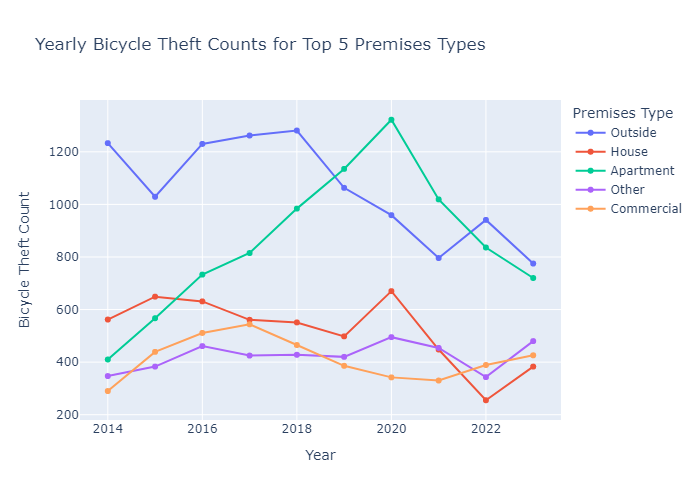

In [64]:
# Group the data by 'OCC_YEAR' and 'PREMISES_TYPE', and calculate the theft count
agg_bicycle_theft_year = filtered_bicycle_theft_data4.groupby(['OCC_YEAR', 'PREMISES_TYPE']).size().reset_index(name='bicycle_theft_Count')

# Sort the grouped data by 'bicycle_theft_Count' in descending order
agg_bicycle_theft_year = agg_bicycle_theft_year.sort_values(['OCC_YEAR', 'bicycle_theft_Count'], ascending=[True, False])

# Filter to keep only the top 5 premises for each year
top_5_premises_by_year = agg_bicycle_theft_year.groupby('OCC_YEAR').head(5)

# Create a time series plot 
fig1 = go.Figure()

# Loop through each premises type and add a line trace
for premises_type in top_5_premises_by_year['PREMISES_TYPE'].unique():
    premises_data = top_5_premises_by_year[top_5_premises_by_year['PREMISES_TYPE'] == premises_type]
    fig1.add_trace(go.Scatter(
        x=premises_data['OCC_YEAR'],
        y=premises_data['bicycle_theft_Count'],
        mode='lines+markers',
        name=premises_type
        
    ))

# Update the layout
fig1.update_layout(
    title='Yearly Bicycle Theft Counts for Top 5 Premises Types',
    xaxis_title='Year',
    yaxis_title='Bicycle Theft Count',
    legend_title='Premises Type'
)

# Generate image as bytes
img_bytes = pio.to_image(fig1, format='png')

# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))



* The graph above illustrates the annual count of bicycle thefts in Toronto, aggregated by premises type, highlighting only the top five premises. Over time, the "Outside" premise consistently recorded the highest number of bicycle thefts. However, starting in 2017, the "Apartment" premise saw a rapid increase in thefts, which led this premise to surpass the "Outside" premise from 2019 to 2021. It is crucial to ensure that bicycles are securely locked or attended to, especially in these types of premises.


##### How does the number of bicycle thefts vary across different time periods of the day?

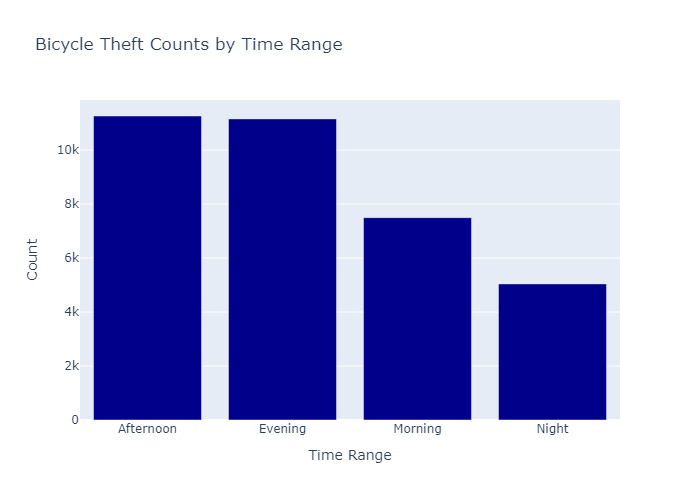

In [65]:
# Define the function to categorize the time range
def categorize_time(hour):
    if 0 <= hour < 6:
        return "Night"
    elif 6 <= hour < 12:
        return "Morning"
    elif 12 <= hour < 18:
        return "Afternoon"
    elif 18 <= hour <= 23:
        return "Evening"
    else:
        return "Unknown" 

# Apply the function to create the 'TimeRange' column
filtered_bicycle_theft_data4['TimeRange'] = filtered_bicycle_theft_data4['OCC_HOUR'].apply(categorize_time)

agg_bicycle_theft_TimePeriod = filtered_bicycle_theft_data4.groupby(['TimeRange']).size().reset_index(name='bicycle_theft_Count')

# Create a bar chart using plotly.graph_objects
fig2 = go.Figure()

# Add bars for each time range
fig2.add_trace(go.Bar(
    x=agg_bicycle_theft_TimePeriod['TimeRange'],
    y=agg_bicycle_theft_TimePeriod['bicycle_theft_Count'],
    marker_color='darkblue'
))

# Update the layout
fig2.update_layout(
    title='Bicycle Theft Counts by Time Range',
    xaxis_title='Time Range',
    yaxis_title='Count',
    
)

# Generate image as bytes
img_bytes = pio.to_image(fig2, format='png')

# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))



* The graph above illustrates the count of bicycle thefts in Toronto, categorized by time periods of the day. It reveals that the afternoon (12:00 PM - 5:59 PM) and evening (6:00 PM - 11:59 PM) time periods have the highest number of recorded thefts, with over 11,000 incidents each since 2014. On the other hand, the night period (12:00 AM - 5:59 AM) records the fewest thefts. The data suggests that bicycle thieves are most active from midday to midnight, with peak occurences happening in the afternoon and evening hours. This pattern may be linked to higher cyclist activity during these times, which provides more opportunities for theft.

##### Are there specific days of the week or months that experience a higher incidence of bicycle thefts?

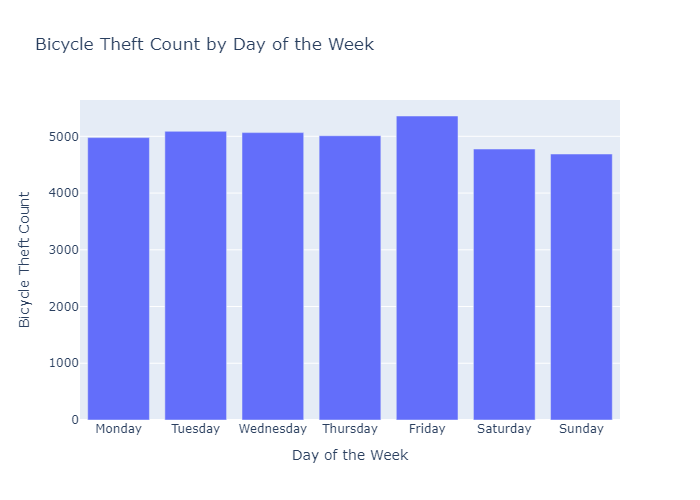

In [66]:
# Group the data by 'Day of Week', and calculate the theft count
agg_bicycle_theft_DOW = filtered_bicycle_theft_data4.groupby(['OCC_DOW']).size().reset_index(name='bicycle_theft_Count')

# Group the data by 'Month', and calculate the theft count
agg_bicycle_theft_Month = filtered_bicycle_theft_data4.groupby(['OCC_MONTH']).size().reset_index(name='bicycle_theft_Count')

# Define the correct order for days of the week and months of the year
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Convert OCC_DOW to categorical type with the correct order
agg_bicycle_theft_DOW['OCC_DOW'] = pd.Categorical(agg_bicycle_theft_DOW['OCC_DOW'], categories=days_of_week, ordered=True)

# Convert OCC_MONTH to categorical type with the correct order
agg_bicycle_theft_Month['OCC_MONTH'] = pd.Categorical(agg_bicycle_theft_Month['OCC_MONTH'], categories=months_of_year, ordered=True)

# Sort the grouped data by the correct order
agg_bicycle_theft_DOW = agg_bicycle_theft_DOW.sort_values(by='OCC_DOW')
agg_bicycle_theft_Month = agg_bicycle_theft_Month.sort_values(by='OCC_MONTH')

# Create bar chart for days of the week
fig_dow = go.Figure()
fig_dow.add_trace(go.Bar(
    x=agg_bicycle_theft_DOW['OCC_DOW'],
    y=agg_bicycle_theft_DOW['bicycle_theft_Count'],
    name='Bicycle Theft Count'
))
fig_dow.update_layout(
    title='Bicycle Theft Count by Day of the Week',
    xaxis_title='Day of the Week',
    yaxis_title='Bicycle Theft Count'
)

# Create time series chart for months
fig_month = go.Figure()
fig_month.add_trace(go.Scatter(
    x=agg_bicycle_theft_Month['OCC_MONTH'],
    y=agg_bicycle_theft_Month['bicycle_theft_Count'],
    mode='lines+markers',
    name='Bicycle Theft Count'
))
fig_month.update_layout(
    title='Bicycle Theft Count by Month',
    xaxis_title='Month',
    yaxis_title='Bicycle Theft Count'
)

# Generate image as bytes
img_bytes = pio.to_image(fig_dow, format='png')
# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))



* The graph above illustrates the count of bicycle thefts in Toronto, aggregated by day of the week. Although Friday shows a slightly higher number of thefts, the overall proportion of thefts remains relatively consistent across all days. This suggests that there is no significant variation in theft occurrences throughout the week, and thus we cannot conclude that bicycle thefts occurences are disproportionately affected by any particular day of the week.

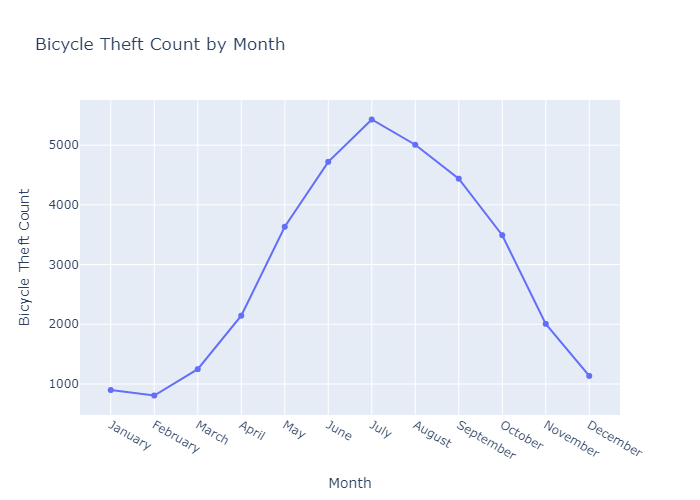

In [67]:
# Generate image as bytes
img_bytes = pio.to_image(fig_month, format='png')
# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))

* The graph above illustrates the monthly count of bicycle thefts in Toronto, with July recording the highest number of incidents. This is followed by June and August, reflecting a trend consistent with the summer months. The time series reveals a seasonal cycle, indicating that weather conditions likely impact theft frequency. Every year, as spring approaches, bicycle theft awareness campaigns could be intensified as a reminder to stay safe and secure bicycles effectively in anticipation of the seasonal increase in thefts.


##### Which areas experience the highest rates of bicycle theft?

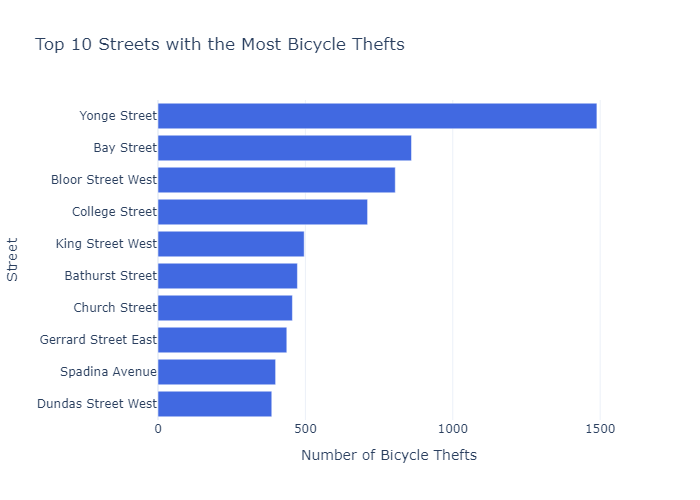

In [68]:
# Group the data by 'Road', and calculate the theft count
agg_bicycle_theft_street = filtered_bicycle_theft_data4.groupby(['Road']).size().reset_index(name='bicycle_theft_Count')

# Sort the grouped data by 'bicycle_theft_Count' in descending order
agg_bicycle_theft_street = agg_bicycle_theft_street.sort_values(['bicycle_theft_Count'], ascending=[False])

top_10_streets = agg_bicycle_theft_street.head(10).sort_values(by='bicycle_theft_Count', ascending=True)

# Create the bar chart
fig3 = go.Figure()

# Add the bar trace
fig3.add_trace(go.Bar(
    x=top_10_streets['bicycle_theft_Count'],
    y=top_10_streets['Road'],
    orientation='h',  
    marker=dict(color='royalblue'),  
))

# Indicate layout features
fig3.update_layout(
    title='Top 10 Streets with the Most Bicycle Thefts',
    xaxis_title='Number of Bicycle Thefts',
    yaxis_title='Street',
    yaxis=dict(tickvals=top_10_streets['Road']),  
    template='plotly_white',  
)

# Generate image as bytes
img_bytes = pio.to_image(fig3, format='png')
# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))

* The graph above illustrates the count of bicycle thefts in Toronto, aggregated by street names, highlighting only the top 10 streets. The data suggest that Yonge Street has the highest number of bicycle thefts, with close to 1,500 incidents, compared to Bay Street, which ranks second with fewer than 900 incidents. This significant disparity indicates that Yonge Street is more prone to bicycle theft than other streets in Toronto. Since Yonge Street is a popular destination, the high volume of thefts may be attributed to its heavy foot traffic and high density of cyclists. While cycling to areas such as Yonge Street, Bay Street, Bloor Street West, or College Street, it is crucial to remain extra vigilant and ensure that bicycles are securely locked or attended to, especially in these high-risk areas.

In [69]:
# Filter DataFrame for the year 2022
df_previous_full_year= filtered_bicycle_theft_data4[filtered_bicycle_theft_data4['OCC_YEAR'] > last_year -3 ]

# Center the map based on the median coordinates
map_center = [df_previous_full_year['Latitude'].median(), df_previous_full_year['Longitude'].median()]
theft_occurrence_map = folium.Map(location=map_center, zoom_start=10)


# Add small dots to the map
for _, row in df_previous_full_year.iterrows():
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        radius=1, 
        color='blue',  
        fill=True,
        fill_color='blue',  
        fill_opacity=0.6,  
    ).add_to(theft_occurrence_map)

# Display interactive map
theft_occurrence_map

* The Map above illustrates all the specific location of bicycle thefts occurances in Toronto, in the last 3 years. I filtered the dataset to prevent the interactive map from crashing. The data clearly shows a persistent concentration of thefts in the downtown area (this is also true for the years not included in the map).  Many people go downtown daily, hence the high volume of thefts may be attributed to its heavy foot traffic and high density of cyclists. While cycling to the downtown area, it is crucial to remain extra vigilant and ensure that bicycles are securely locked or attended to.
* Note: You can zoom in and out of the map to see street names, parks etc.

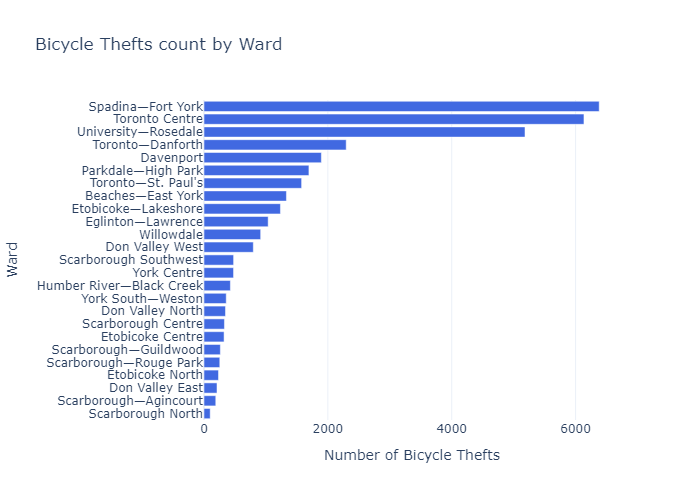

In [70]:
# Group the data by 'Quarter'(ward), and calculate the theft count
agg_bicycle_theft_ward = filtered_bicycle_theft_data4.groupby(['Quarter']).size().reset_index(name='bicycle_theft_Count')

# Sort the grouped data by 'bicycle_theft_Count' in descending order
agg_bicycle_theft_ward = agg_bicycle_theft_ward.sort_values(['bicycle_theft_Count'], ascending=[True])


# Create the bar chart
fig4 = go.Figure()

# Add the bar trace
fig4.add_trace(go.Bar(
    x=agg_bicycle_theft_ward['bicycle_theft_Count'],
    y=agg_bicycle_theft_ward['Quarter'],
    orientation='h',  # Horizontal bar chart
    marker=dict(color='royalblue'), 
))

# Indicate layout features
fig4.update_layout(
    title='Bicycle Thefts count by Ward',
    xaxis_title='Number of Bicycle Thefts',
    yaxis_title='Ward',
    yaxis=dict(tickvals=agg_bicycle_theft_ward['Quarter']),  
    template='plotly_white',  
)

# Generate image as bytes
img_bytes = pio.to_image(fig4, format='png')
# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))


* The graph above illustrates the count of bicycle thefts in Toronto, aggregated by ward. As we saw with the interactive map above, the downtown area is the area with the most bicycle thefts and thus the wards with the most bicycle thefs occurrances are the ones that cover the downtown area such as Spadina-Fort York, Tonronto center, and University-Rosedale. It is crucial to remain extra vigilant and ensure that bicycles are securely locked or attended to, especially in these high-risk areas.

##### Other interesting insights.

In [71]:
# Convert columns to datetime
filtered_bicycle_theft_data4['Occ_Full_Date'] = pd.to_datetime(filtered_bicycle_theft_data4['Occ_Full_Date'])
filtered_bicycle_theft_data4['Report_Full_Date'] = pd.to_datetime(filtered_bicycle_theft_data4['Report_Full_Date'])

# Count of items in the dataset
total_theft_count = len(filtered_bicycle_theft_data4)

# Count how many years in the dataset
total_days_count = len(filtered_bicycle_theft_data4['Occ_Full_Date'].unique())

# Gets average stolen bicycles per day 
stolen_bicycle_per_day = total_theft_count/total_days_count

# Get Total cost of all stolen bicycles
total_BIKE_COST = filtered_bicycle_theft_data4['BIKE_COST'].sum()

# Change column type to date
filtered_bicycle_theft_data4['Report_Time_Difference'] = (filtered_bicycle_theft_data4['Report_Full_Date'] - filtered_bicycle_theft_data4['Occ_Full_Date']).dt.days

# Get average report delay time
average_report_delay = filtered_bicycle_theft_data4['Report_Time_Difference'].mean()

# Count of recovered Bicycles
recovered_count = filtered_bicycle_theft_data4[filtered_bicycle_theft_data4['STATUS'] == 'RECOVERED'].shape[0]

# Recovery Rate
recovery_rate = recovered_count / total_theft_count

print(f"Insights from the last 10 full calendar year:\n")
print(f"Count of bicycle theft occurences: {total_theft_count:,}")
print(f"Esimated amount of bicycle thefts per day: {stolen_bicycle_per_day:.2f}")
print(f"The Recovery rate of a stolen bicycle is: {recovery_rate:.2%}")
print(f"Total value loss of stolen bicycles: ${total_BIKE_COST:,.2f}")
print(f"Average report delay in days: {average_report_delay:.2f}")



Insights from the last 10 full calendar year:

Count of bicycle theft occurences: 34,962
Esimated amount of bicycle thefts per day: 9.96
The Recovery rate of a stolen bicycle is: 1.04%
Total value loss of stolen bicycles: $36,585,660.93
Average report delay in days: 7.64


* The calculations above provide additional insights into trends in bicycle theft in Toronto. 
    * With 34,962 occurances in the last 10 full calendar year, there is about 10 stolen bicycle occurance every day.
    * With a recovery rate of 1.04%, it is highly unlikely that an individual will recover their stolen bicycle.
    * On average, it takes about a week for individual to report their stolen bicycle to the police.
    * The total loss of value of stolen bicycle is more than 36 million dollars (this includes outliers).

# External Factors Analysis <a class="anchor" id="section-4"></a>

### What impact does the rising cost of living have on bicycle theft? <a class="anchor" id="section-5"></a>

#### To answer this question, I decided to evaluate the correlation between the consumer price index in canada and the count of bicycle thefts.

In [72]:
# Group the bicycle theft data by year and month, and calculate the total thefts for each group.
agg_bicycle_theft_data1 = filtered_bicycle_theft_data4.groupby(['Year-Month']).size().reset_index(name='bicycle_theft_Count')

# Merge the resampled theft data with the CPI data
bicycle_CPI_merged_data = pd.merge(agg_bicycle_theft_data1, cpi_data1, on='Year-Month')

# Calculate the correlation between 'Bicycle Theft' and 'CPI'
correlation_bicycle_theft_CPI_Value = bicycle_CPI_merged_data[['bicycle_theft_Count', 'CPI_Inflation']].corr().iloc[0, 1]
correlation_bicycle_theft_Total_CPI = bicycle_CPI_merged_data[['bicycle_theft_Count', 'CPI_Base']].corr().iloc[0, 1]

print(f"Correlation between Bicycle Theft Count and CPI Inflation: {correlation_bicycle_theft_CPI_Value}")
print(f"Correlation between Bicycle Theft Count and CPI Base: {correlation_bicycle_theft_Total_CPI}")


Correlation between Bicycle Theft Count and CPI Inflation: -0.09089106314936835
Correlation between Bicycle Theft Count and CPI Base: -0.03130667320310187


#### I also chose to visualize a time series of bicycle thefts with a trend line, alongside the consumer price index.

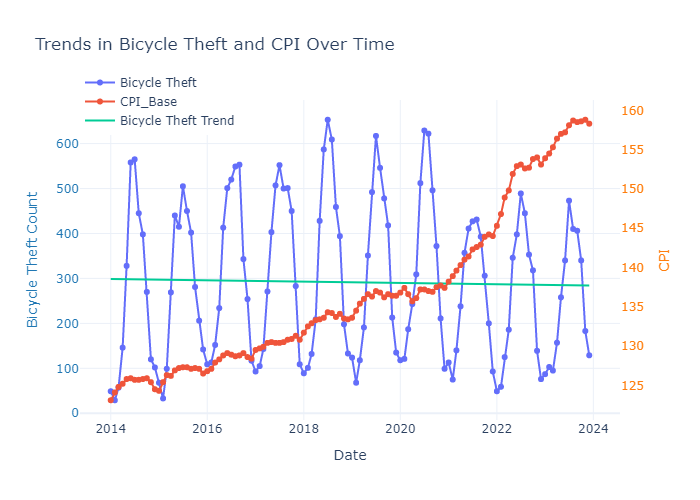

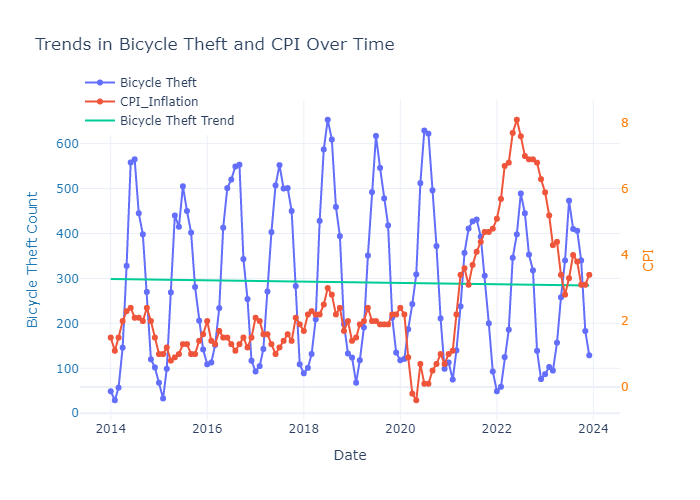

In [73]:
# Create copy of dataframe
df= bicycle_CPI_merged_data.copy()

# Change column format
df['Year-Month'] = pd.to_datetime(df['Year-Month'])
df['CPI_Base'] = df['CPI_Base'].astype(float)
df['CPI_Inflation'] = df['CPI_Inflation'].astype(float)

# Calculate the trend line for bicycle_theft_Count
X = np.arange(len(df)).reshape(-1, 1) 
y = df['bicycle_theft_Count']
model = LinearRegression().fit(X, y)
trend_line = model.predict(X)


# Create the time series chart
fig5 = go.Figure()

# Add the first series to the primary y-axis
fig5.add_trace(go.Scatter(x=df['Year-Month'], y=df['bicycle_theft_Count'], mode='lines+markers', name='Bicycle Theft'))

# Add the second series to the secondary y-axis
fig5.add_trace(go.Scatter(x=df['Year-Month'], y=df['CPI_Base'], mode='lines+markers', name='CPI_Base', yaxis='y2'))
fig5.add_trace(go.Scatter(x=df['Year-Month'], y=trend_line, mode='lines', name='Bicycle Theft Trend'))


# Indicate layout features
fig5.update_layout(
    title='Trends in Bicycle Theft and CPI Over Time',
    xaxis_title='Date',
    yaxis_title='Bicycle Theft Count',
    yaxis=dict(
        title='Bicycle Theft Count',
        titlefont=dict(color='#1f77b4'),
        tickfont=dict(color='#1f77b4')
    ),
    yaxis2=dict(
        title='CPI',
        titlefont=dict(color='#ff7f0e'),
        tickfont=dict(color='#ff7f0e'),
        anchor='x',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(x=0, y=1.1),
    template='plotly_white'
)

############################################################
# Create the time series chart
fig6 = go.Figure()

# Add the first series to the primary y-axis
fig6.add_trace(go.Scatter(x=df['Year-Month'], y=df['bicycle_theft_Count'], mode='lines+markers', name='Bicycle Theft'))

# Add the second series to the secondary y-axis
fig6.add_trace(go.Scatter(x=df['Year-Month'], y=df['CPI_Inflation'], mode='lines+markers', name='CPI_Inflation', yaxis='y2'))

fig6.add_trace(go.Scatter(x=df['Year-Month'], y=trend_line, mode='lines', name='Bicycle Theft Trend'))

# Indicate layout features
fig6.update_layout(
    title='Trends in Bicycle Theft and CPI Over Time',
    xaxis_title='Date',
    yaxis_title='Bicycle Theft Count',
    yaxis=dict(
        title='Bicycle Theft Count',
        titlefont=dict(color='#1f77b4'),
        tickfont=dict(color='#1f77b4')
    ),
    yaxis2=dict(
        title='CPI',
        titlefont=dict(color='#ff7f0e'),
        tickfont=dict(color='#ff7f0e'),
        anchor='x',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(x=0, y=1.1),
    template='plotly_white'
)


# Generate image as bytes
img_bytes = pio.to_image(fig5, format='png')
# Display image
display(Image(img_bytes))

# Generate image as bytes
img_bytes2 = pio.to_image(fig6, format='png')
# Display image
display(Image(img_bytes2))


#### Conclusion: What impact does the rising cost of living have on bicycle theft?
##### Answer: I used the Consumer Price Index (CPI), a measure of inflation, to assess whether the recent rise in inflation has impacted bicycle theft. The data suggest that CPI does not appear to influence bicycle theft rates.
* 1) The correlation coefficients between CPI values and bicycle theft were -0.09 and -0.03, indicating a very weak linear relationship between these variables. These low correlation values suggest that changes in CPI have little to no impact on bicycle theft.
* 2) The trend line of bicycle thefts over time shows a slight but consistent decrease. In contrast, the base-year CPI has risen from approximately 123 in January 2014 to 158 by December 2023. This suggests that despite the increase in CPI (base), the number of bicycle thefts has remained relatively stable. Therefore, the rising cost of living does not appear to affect bicycle theft rates.



### What weather conditions most influence bicycle theft? <a class="anchor" id="section-6"></a>

#### To answer this question, I evaluated the correlation between daily weather conditions in Toronto and the daily number of bicycle thefts.

In [74]:
# Aggregation to get daily counts
daily_bicycle_theft = filtered_bicycle_theft_data4.groupby('Occ_Full_Date').size().reset_index(name='theft_count')
daily_bicycle_theft.rename(columns={'Occ_Full_Date': 'date'}, inplace=True)

# change columns format
daily_bicycle_theft['date'] = pd.to_datetime(daily_bicycle_theft['date'])
filtered_weather_data1['date'] = pd.to_datetime(filtered_weather_data1['date'])

# Merge bicycle theft dataset with weather dataset
wheater_bicycle_merged_data = pd.merge(daily_bicycle_theft, filtered_weather_data1, on='date')


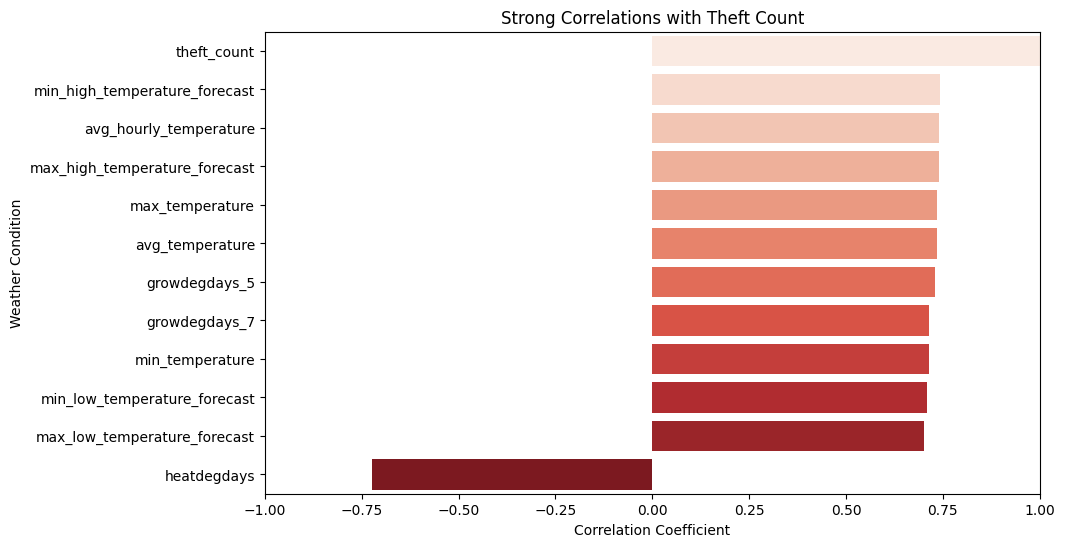

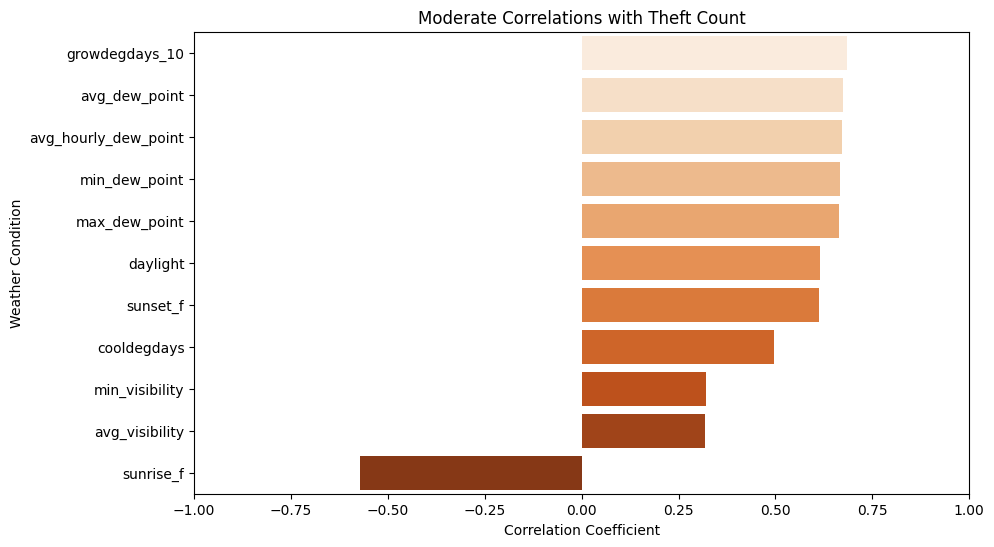

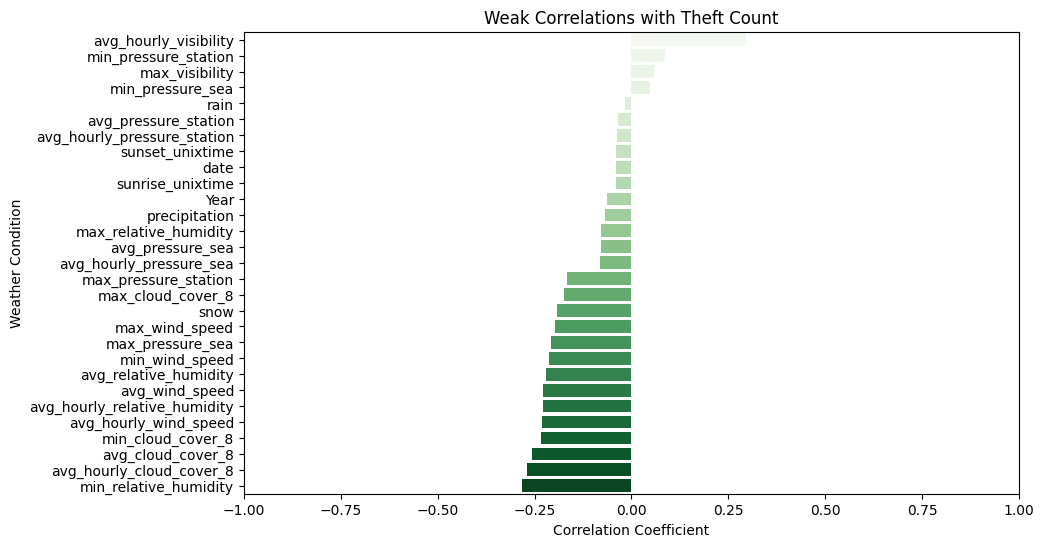

In [75]:
# Correlation against bicycle theft count
correlation = wheater_bicycle_merged_data.corr()['theft_count']

# Create df with the correlation data
correlation_df = pd.DataFrame(correlation).sort_values(by="theft_count", ascending=False).reset_index()
correlation_df.columns = ['Column', 'theft_count']

# Define correlation strength categories
def categorize_correlation(value):
    if abs(value) > 0.7:
        return 'Strong'
    elif abs(value) > 0.3:
        return 'Moderate'
    else:
        return 'Weak'

# New column in correlation df for correlation strength
correlation_df['Category'] = correlation_df['theft_count'].apply(categorize_correlation)

# Filter columns based on categories
strong_corr = correlation_df[correlation_df['Category'] == 'Strong']
moderate_corr = correlation_df[correlation_df['Category'] == 'Moderate']
weak_corr = correlation_df[correlation_df['Category'] == 'Weak']

# Plotting
def plot_correlation(df, title, color):
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='theft_count', y='Column', hue='Column', dodge=False, palette=color, legend=False)
    plt.title(title)
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Weather Condition')
    plt.xlim(-1, 1)
    plt.show()

# Show graphs
plot_correlation(strong_corr, 'Strong Correlations with Theft Count', 'Reds')
plot_correlation(moderate_corr, 'Moderate Correlations with Theft Count', 'Oranges')
plot_correlation(weak_corr, 'Weak Correlations with Theft Count', 'Greens')

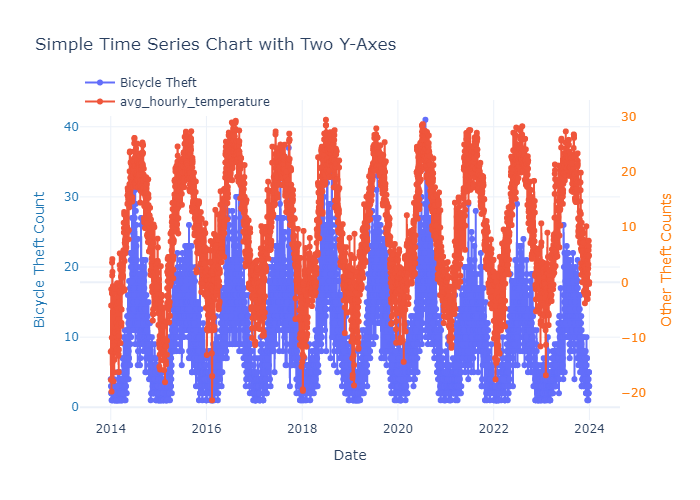

In [76]:
# Make copy of dataframe
df = wheater_bicycle_merged_data.copy()

# Change colum types
df['date'] = pd.to_datetime(df['date'])


# Calculate the trend line for bicycle_theft_Count
X = np.arange(len(df)).reshape(-1, 1)  
y = df['theft_count']
model = LinearRegression().fit(X, y)
trend_line = model.predict(X)


# Create the time series chart
fig7 = go.Figure()

# Add the first series to the primary y-axis
fig7.add_trace(go.Scatter(x=df['date'], y=df['theft_count'], mode='lines+markers', name='Bicycle Theft'))

# Add the second series to the secondary y-axis
fig7.add_trace(go.Scatter(x=df['date'], y=df['avg_hourly_temperature'], mode='lines+markers', name='avg_hourly_temperature', yaxis='y2'))


# Trends in Temperature and Bicycle Theft Overtime
fig7.update_layout(
    title='Simple Time Series Chart with Two Y-Axes',
    xaxis_title='Date',
    yaxis_title='Bicycle Theft Count',
    yaxis=dict(
        title='Bicycle Theft Count',
        titlefont=dict(color='#1f77b4'),
        tickfont=dict(color='#1f77b4')
    ),
    yaxis2=dict(
        title='Other Theft Counts',
        titlefont=dict(color='#ff7f0e'),
        tickfont=dict(color='#ff7f0e'),
        anchor='x',
        overlaying='y',
        side='right',
        showgrid=False
    ),
    legend=dict(x=0, y=1.1),
    template='plotly_white'
)

# Generate image as bytes
img_bytes = pio.to_image(fig7, format='png')
# Display the graph as a static image in the cell, as the interactive graph does not render properly when the Python file is uploaded to GitHub.
display(Image(img_bytes))



#### Conclusion: Which weather conditions most influence bicycle theft?
##### Answer: The weather dataset we used had many different weather conditions such as temperature, humidity, wind speed, visivility, cloud cover, rain, snow and more. Our data suggest that the weather conditions that have the biggest impact on bicycle theft are the following: Temperature (including other fields derived from this measurement) and daylight (including other fields influenced by this measurement).
* 1) Temperature: The correlation coefficient between the average hourly temperature and bicycle theft is 0.739. This indicates a strong positive relationship between these two variables, suggesting that as the average hourly temperature increases, the incidences of bicycle theft also tends to increase. Additionally, other temperature-related variables in the dataset exhibit significant correlations with bicycle theft. These include: Growing Degree Days (growdegdays_10), Dew Point (avg_dew_point), and Heat Degree Days (heatdegdays).    
* 2) Dailylight: The correlation coefficient between daylight and bicycle theft is 0.61, indicating a relatively strong positive relationship between these two variables. This means that as the amount of daylight increases, the incidences of bicycle theft also tends to rise. Additionally, the correlation coefficient between sunset, which is influenced by the amount of daylight on any given day, and bicycle theft is also 0.61. Both these factors (Daylight and Sunset) show a relatively significant positive correlation with bicycle theft.


### How do varying education levels across different wards impact bicycle theft rates?<a class="anchor" id="section-7"></a>

#### To answer this question, I first examined the correlation between the population's education level and bicycle theft.

In [77]:
# Aggregation to get daily counts
yearly_bicycle_theft = filtered_bicycle_theft_data4.groupby(['OCC_YEAR', 'Quarter']).size().reset_index(name='theft_count')

# Only retain 2021 data, the census is only availalble for a few selected years.
yearly_bicycle_theft_2021 = yearly_bicycle_theft[yearly_bicycle_theft['OCC_YEAR'] == 2021]

# Merge de Data set
bicycle_census_merged_data = pd.merge(census_data, yearly_bicycle_theft_2021, on='Quarter')

# Create new df without 'Quarter' column (categorical field) to be able to perform correlation analysis 
corr_bicycle_census_merged_data = bicycle_census_merged_data.drop(['Quarter'], axis=1)

In [78]:
# Correlation against bicycle theft count
correlation  = corr_bicycle_census_merged_data.corr()['theft_count']

# Create df with the correlation data
correlation_df = pd.DataFrame(correlation).sort_values(by="theft_count", ascending=False).reset_index()
correlation_df.columns = ['Column', 'theft_count']

# Show values
correlation.sort_values(ascending=False)

theft_count                                                  1.000000
Bachelor’s degree or higher                                  0.763292
Postsecondary certificate or diploma below bachelor level   -0.384670
No certificate, diploma or degree                           -0.535722
OCC_YEAR                                                          NaN
Name: theft_count, dtype: float64

#### Then, I decided to do a regression analysis to gain further insight on the correlation between educational levels.

In [79]:
# Make copy of dataframe
df2 = bicycle_census_merged_data.copy()

# Converts 'Quarter' column to dummy variables
df2 = pd.get_dummies(df2, columns=['Quarter'], drop_first=True)

# Define dependent variable
y = df2['theft_count']

# Define independent variables
X = df2[['No certificate, diploma or degree', 'Bachelor’s degree or higher', 'Postsecondary certificate or diploma below bachelor level'] + [col for col in df.columns if col.startswith('Quarter_')]]

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            theft_count   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.609
Method:                 Least Squares   F-statistic:                     13.48
Date:                Wed, 21 Aug 2024   Prob (F-statistic):           4.00e-05
Time:                        08:40:33   Log-Likelihood:                -147.79
No. Observations:                  25   AIC:                             303.6
Df Residuals:                      21   BIC:                             308.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------

#### Conclusion: How do varying education levels across different wards impact bicycle theft rates?
##### Answer: I analyzed data from the 2021 census to gain insights into the educated population across different wards in Toronto. The analysis focused on three categories of education : 'Bachelor’s degree or higher', 'Postsecondary certificate or diploma below the Bachelor’s level', and 'No certificate, diploma, or degree'. The data reveals a strong statistical significance between wards with a higher population of individuals holding a Bachelor's degree or higher. This suggests that wards with a larger number of graduates at this educational level tend to experience more bicycle thefts. On the other hand, educational levels such as 'Postsecondary certificate or diploma below the Bachelor’s level' and 'No certificate, diploma, or degree' were not found to be statistically significant. As a result, we cannot confidently determine the impact of these educational levels on bicycle theft rates.
* 1) Correlation coefficient: 
        * Bachelor’s Degree or Higher and Bicycle Theft: The correlation coefficient is 0.76, indicating a strong positive relationship. This suggests that wards with a higher percentage of individuals holding a bachelor's degree or higher are more likely to experience bicycle theft.
        * Postsecondary certificate or diploma below bachelor level and bicycle theft: The correlation coefficient is -0.53, reflecting a moderate negative relationship. This implies that wards with a higher percentage of individuals holding a postsecondary certificate or diploma below the bachelor’s level tend to experience fewer incidents of bicycle theft.
        * No certificate, diploma, or degree and bicycle theft: The correlation coefficient is -0.38, reflecting a moderate negative relationship. This means that wards with a higher percentage of individuals without any certificate, diploma, or degree are less likely to experience bicycle theft, although this negative correlation is weaker compared to the -0.53 correlation observed for postsecondary certificates or diplomas below the bachelor’s level.

* 2) Regression analysis: The computed R-squared was 0.658 wich implies that 65% of the variance in bicycle theft count can be explained by one or more of the three selected educational levels.
        * Bachelor’s degree or higher:
            * This educational level had the lowest Standard Error among the three educational levels used. The computed Standard Error is 0.002, indicating precise estimates of the regression coefficient.  
            * This educational level is the only one with a statistically significant coefficient, as evidenced by a P-value lower than 5%. The computed P-value is 0.000. 
            * Additionally, this educational level is statistically significant, as evidenced by a confidence interval that does not include zero.The other educational levels have confidence intervals that include zero, indicating a lack of statistical significance. The computed confidence interval for 'Bachelor’s degree or higher' is [0.006, 0.015].
   


# Power BI Visualization <a class="anchor" id="section-8"></a>

#### While the bicycle theft analysis is mainly complete, I decided to also represent the data in Power BI which provides a more dynamic way of visualizing the data than python. I exported the cleaned bicycle theft dataset into an excel file and created a dynamic dashboard using Power BI.

In [80]:
# Save the DataFrame to an Excel file for use in Power BI for visualization
filtered_bicycle_theft_data4.to_excel('TOR_Data.xlsx', index=False) 